In [1]:
import pandas as pd
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn as sk
import requests
import time
from sklearn.model_selection import train_test_split
from sklearn import linear_model 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler

In [2]:
# 정제된 데이터가져오기
df = pd.read_csv("df1_16.csv", encoding='utf-8')
df.head(1)


,year,quarter,district,code,workpop,floatpop,prop_2030s,prop_06_11,prop_11_14,prop_14_17,...,no_of_store,no_of_franch_store,no_of_bank,no_of_pharm,no_of_theartre,no_of_accom,no_of_STA,sales,sales_female_ratio,sales_weekday_ratio
0,2018,1,1000001,CS100001,831.0,188508.0,0.409338,0.011467,0.407748,0.151499,...,15.0,0.0,0.0,0.0,16.0,38.0,0.0,922621269.0,0.351752,0.70405


In [3]:
# 시군구 데이터 가져오기
cgoongoo=pd.read_csv("cgoongoo1.csv", encoding='utf-8')
cgoongoo.head(1)

,district,cgoongoo
0,1001453,11620


In [4]:
# 시군구와 정제된 데이터 머지
df1=pd.merge(df, cgoongoo, on=['district'])
df1.head()

,year,quarter,district,code,workpop,floatpop,prop_2030s,prop_06_11,prop_11_14,prop_14_17,...,no_of_franch_store,no_of_bank,no_of_pharm,no_of_theartre,no_of_accom,no_of_STA,sales,sales_female_ratio,sales_weekday_ratio,cgoongoo
0,2018,1,1000001,CS100001,831.0,188508.0,0.409338,0.011467,0.407748,0.151499,...,0.0,0.0,0.0,16.0,38.0,0.0,922621269.0,0.351752,0.704050,11110
1,2018,1,1000001,CS100002,831.0,188508.0,0.473122,0.004000,0.504362,0.157013,...,1.0,0.0,0.0,16.0,38.0,0.0,176034744.0,0.324470,0.769975,11110
2,2018,1,1000001,CS100003,831.0,188508.0,0.440999,0.000000,0.653076,0.120070,...,0.0,0.0,0.0,16.0,38.0,0.0,45454124.0,0.358348,0.848584,11110
3,2018,1,1000001,CS100004,831.0,188508.0,0.575315,0.000597,0.325943,0.269932,...,0.0,0.0,0.0,16.0,38.0,0.0,351079289.0,0.494218,0.548148,11110
4,2018,1,1000001,CS100005,831.0,188508.0,0.503582,0.000282,0.612311,0.163809,...,1.0,0.0,0.0,16.0,38.0,0.0,163624875.0,0.490051,0.845680,11110


In [34]:
cgoon_ls=np.unique(df1.cgoongoo)
# cgoon_ls2=list(map(lambda x: "c_{}".format(x), cgoon_ls ))
# cgoon_ls2

In [8]:
df1.drop(['year','quarter','district'],axis=1,inplace=True)


In [15]:
df2=df1[['cgoongoo','code','sales', 'workpop', 'floatpop', 'prop_2030s', 'prop_06_11', 'prop_11_14',
       'prop_14_17', 'prop_17_21', 'prop_21_24', 'apt_no_of_cmplx',
       'apt_avg_space', 'apt_avg_price', 'inc_monthly_avg', 'expnd_total',
       'no_of_store', 'no_of_franch_store', 'no_of_bank', 'no_of_pharm',
       'no_of_theartre', 'no_of_accom', 'no_of_STA',
       'sales_female_ratio', 'sales_weekday_ratio' ]]

In [108]:
## 같은 구끼리 df 따로 만들기
#지금은 1개의 시군구에 대해서만 하지만, 만약 잘 나오면 아래의 과정을 class화 해서 각각의 시군구 마다 회귀분석 모델을 만들 예정
import pickle
# save
with open('cgoongu_each_model.pickle', 'wb') as f:
    pickle.dump(df2, f)

# load
with open('cgoongu_each_model.pickle', 'rb') as f:
    data = pickle.load(f)

In [42]:
df2=df1[df1.cgoongoo== cgoon_ls[0]]
df2=df2[['sales','code', 'workpop', 'floatpop', 'prop_2030s', 'prop_06_11', 'prop_11_14',
       'prop_14_17', 'prop_17_21', 'prop_21_24', 'apt_no_of_cmplx',
       'apt_avg_space', 'apt_avg_price', 'inc_monthly_avg', 'expnd_total',
       'no_of_store', 'no_of_franch_store', 'no_of_bank', 'no_of_pharm',
       'no_of_theartre', 'no_of_accom', 'no_of_STA', 
       'sales_female_ratio', 'sales_weekday_ratio', 'cgoongoo']]

In [43]:
# RobustScaling
x=df2[df2.columns[2:]]

rb = RobustScaler()
rb.fit(x)
X_robust_scaled = rb.transform(x)
dfX=pd.DataFrame(X_robust_scaled, columns= x.columns)
dfX.head(1)

,workpop,floatpop,prop_2030s,prop_06_11,prop_11_14,prop_14_17,prop_17_21,prop_21_24,apt_no_of_cmplx,apt_avg_space,...,no_of_store,no_of_franch_store,no_of_bank,no_of_pharm,no_of_theartre,no_of_accom,no_of_STA,sales_female_ratio,sales_weekday_ratio,cgoongoo
0,0.725389,0.431923,-0.258298,-0.087285,0.910312,-0.443694,0.193419,0.318984,0.0,0.5625,...,3.0,0.0,0.0,0.0,7.5,5.0,0.0,-0.378812,-0.061602,0.0


In [ ]:
df2.code

In [51]:
#서비스코드 더미화
result2 = pd.get_dummies(df2.code)
result2=pd.concat([dfX, result2], axis=1)
result2.drop(columns=['cgoongoo'], inplace=True)
result2.columns

Index(['workpop', 'floatpop', 'prop_2030s', 'prop_06_11', 'prop_11_14',
       'prop_14_17', 'prop_17_21', 'prop_21_24', 'apt_no_of_cmplx',
       'apt_avg_space', 'apt_avg_price', 'inc_monthly_avg', 'expnd_total',
       'no_of_store', 'no_of_franch_store', 'no_of_bank', 'no_of_pharm',
       'no_of_theartre', 'no_of_accom', 'no_of_STA', 'sales_female_ratio',
       'sales_weekday_ratio', 'CS100001', 'CS100002', 'CS100003', 'CS100004',
       'CS100005', 'CS100006', 'CS100007', 'CS100008', 'CS100009', 'CS100010',
       'CS200001', 'CS200002', 'CS200003', 'CS200004', 'CS200005', 'CS200006',
       'CS200007', 'CS200008', 'CS200009', 'CS200010', 'CS200011', 'CS200012',
       'CS200013', 'CS200014', 'CS200015', 'CS200016', 'CS200017', 'CS200018',
       'CS300001', 'CS300002', 'CS300003', 'CS300004', 'CS300005', 'CS300006',
       'CS300007', 'CS300008', 'CS300009', 'CS300010', 'CS300011', 'CS300012',
       'CS300013', 'CS300014', 'CS300015', 'CS300016', 'CS300017'],
      dtype='obje

In [52]:
import numpy as np
np.log(df2['sales'])

0       20.642729
1       18.986192
2       17.632214
3       19.676523
4       18.913087
          ...    
1687    21.675439
1688    18.687086
1689    18.156063
1690    18.211006
1691    18.212384
Name: sales, Length: 1692, dtype: float64

In [54]:
# OLS
import statsmodels.api as sm

X= result2
y= np.log(df2['sales'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

df_train=pd.concat([y_train, X_train], axis=1)

model= sm.OLS.from_formula("sales ~ "+" + ".join(df_train.columns[1:]), data=df_train)
result =  model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     19.99
Date:                Mon, 16 Dec 2019   Prob (F-statistic):          9.18e-143
Time:                        21:10:36   Log-Likelihood:                -1896.5
No. Observations:                1184   AIC:                             3923.
Df Residuals:                    1119   BIC:                             4253.
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              16.8191    

In [56]:
# LASSO 모형
#importing libraries
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [57]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.009616
Best score using built-in LassoCV: 0.438889


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [58]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 38 variables and eliminated the other 29 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

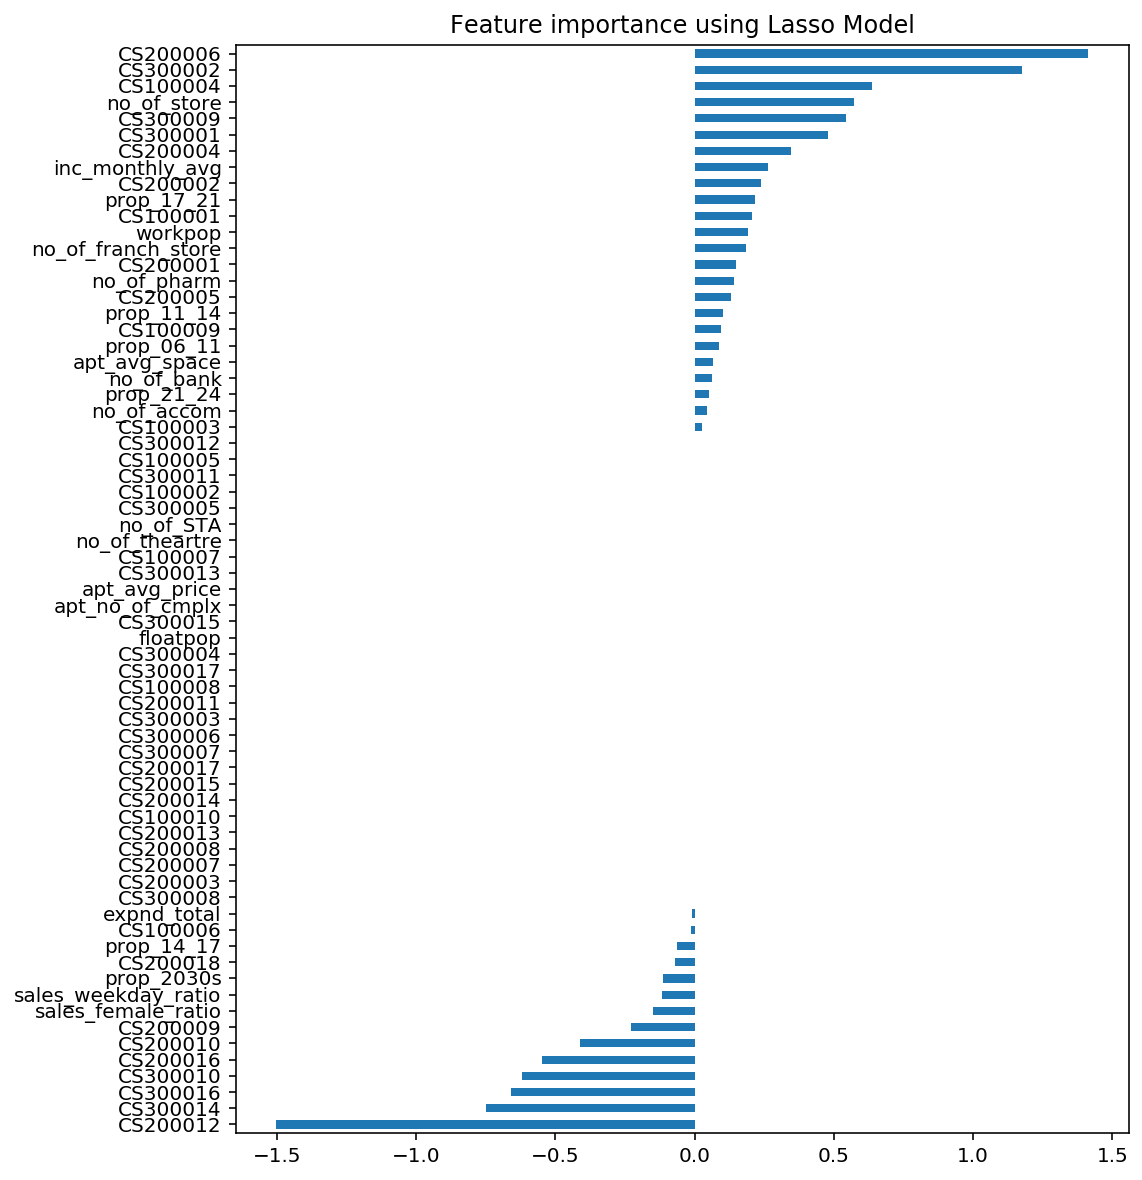

In [59]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [60]:
drop_columns=imp_coef[imp_coef.values==0].index

In [63]:
result2.drop(columns=drop_columns,inplace=True )


In [64]:
result2.columns

Index(['workpop', 'prop_2030s', 'prop_06_11', 'prop_11_14', 'prop_14_17',
       'prop_17_21', 'prop_21_24', 'apt_avg_space', 'inc_monthly_avg',
       'expnd_total', 'no_of_store', 'no_of_franch_store', 'no_of_bank',
       'no_of_pharm', 'no_of_accom', 'sales_female_ratio',
       'sales_weekday_ratio', 'CS100001', 'CS100003', 'CS100004', 'CS100006',
       'CS100009', 'CS200001', 'CS200002', 'CS200004', 'CS200005', 'CS200006',
       'CS200009', 'CS200010', 'CS200012', 'CS200016', 'CS200018', 'CS300001',
       'CS300002', 'CS300009', 'CS300010', 'CS300014', 'CS300016'],
      dtype='object')

In [65]:
# OLS
import statsmodels.api as sm

X= result2
y= np.log(df2['sales'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

df_train=pd.concat([y_train, X_train], axis=1)

model= sm.OLS.from_formula("sales ~ "+" + ".join(df_train.columns[1:]), data=df_train)
result =  model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     30.46
Date:                Mon, 16 Dec 2019   Prob (F-statistic):          8.27e-146
Time:                        21:11:17   Log-Likelihood:                -1934.3
No. Observations:                1184   AIC:                             3947.
Df Residuals:                    1145   BIC:                             4145.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              17.3830    

In [66]:
#오차합 구하기
y_pred = result .predict(X_test)
resid=y_test-y_pred
rss=np.sum(resid**2)
MSE=rss/(result.nobs-2)

#RMSE 구하기
from statsmodels.tools.eval_measures import rmse

rmse = rmse(y_test, y_pred)
MSE, rmse

(0.874523494531669, 1.4264699356922748)

In [67]:
# 모델 생성
lm = linear_model.LinearRegression()

# 학습
lm.fit(X_train, y_train)

# 예측
pred_y = lm.predict(X_train)

print("정확도 : ", str(round(lm.score(X_test, y_test), 4) * 100) + "%")

정확도 :  39.1%


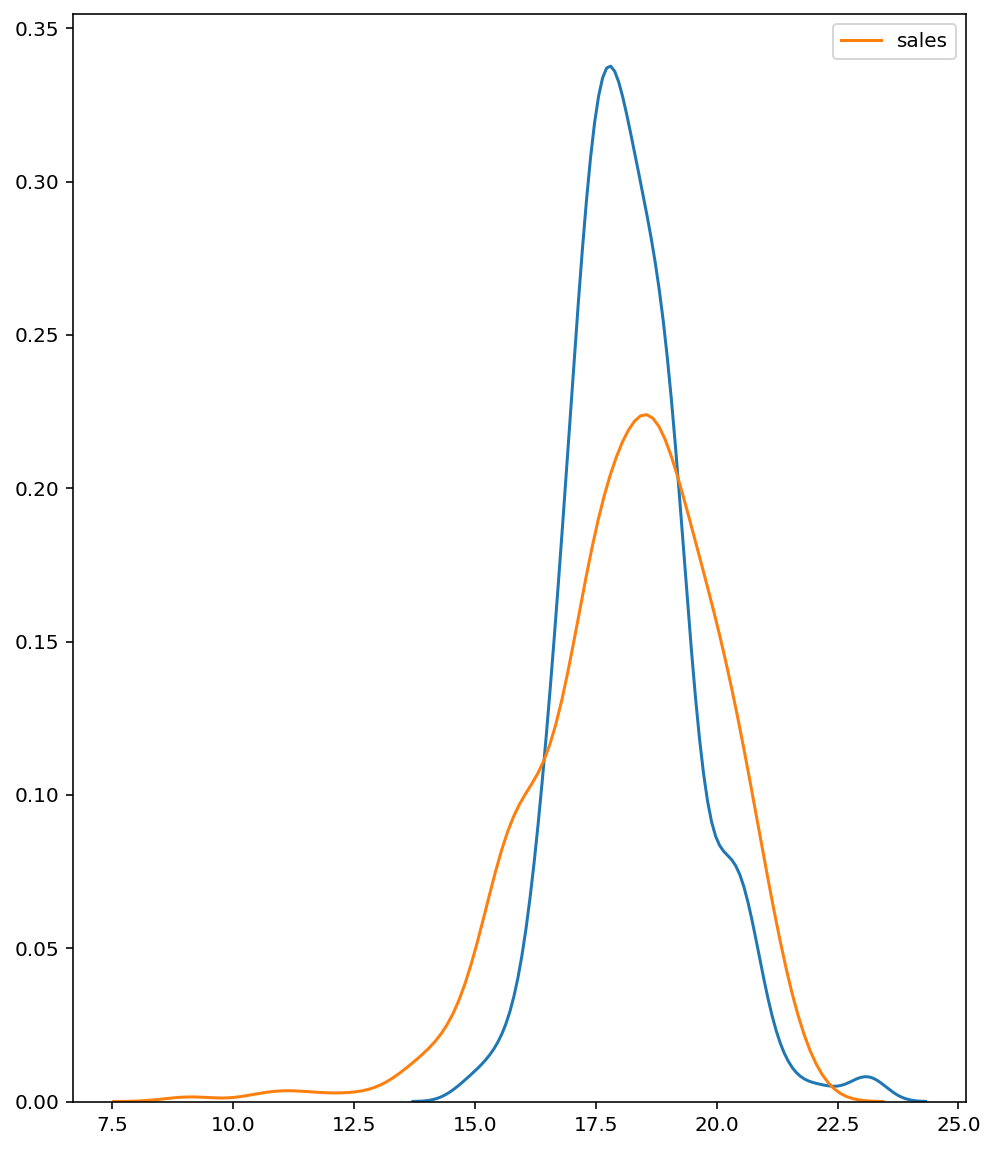

In [68]:
y_pred = result .predict(X_test)
sns.kdeplot(y_pred)
sns.kdeplot(y_test)
# plt.title("")
plt.show()


In [69]:
# 파랑색: 모델링으로 예측한 y_pred 값
# 오렌지: 원래 sales 값

#### 1. 과최적화 일어났는지 K-fold 교차검증

In [70]:
# OLS
import statsmodels.api as sm

X= result2
y= np.log(df2['sales'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

df_train=pd.concat([y_train, X_train], axis=1)

model= sm.OLS.from_formula("sales ~ "+" + ".join(df_train.columns[1:]), data=df_train)
result =  model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     30.46
Date:                Mon, 16 Dec 2019   Prob (F-statistic):          8.27e-146
Time:                        21:11:54   Log-Likelihood:                -1934.3
No. Observations:                1184   AIC:                             3947.
Df Residuals:                    1145   BIC:                             4145.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              17.3830    

In [71]:
from sklearn.model_selection import KFold

df_kfold=pd.concat([y,X], axis=1)
train_r2=[]
test_r2 =[]
scores = np.zeros(5)
cv = KFold(5, shuffle=True)
for i, (idx_train, idx_test) in enumerate(cv.split( df_kfold)):
    df_train =  df_kfold.iloc[idx_train]
    df_test =  df_kfold.iloc[idx_test]
    
    model = sm.OLS.from_formula("sales ~"+"+".join(df_kfold.columns[1:]), data= df_kfold)
    result = model.fit()
    
    pred = result.predict(df_test)
    rss = (( df_kfold.sales - pred) ** 2).sum()
    tss = (( df_kfold.sales -  df_kfold.sales.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))
    train_r2.append(result.rsquared)
    test_r2.append(rsquared)
    


학습 R2 = 0.47546561, 검증 R2 = 0.90184392
학습 R2 = 0.47546561, 검증 R2 = 0.90319199
학습 R2 = 0.47546561, 검증 R2 = 0.88294799
학습 R2 = 0.47546561, 검증 R2 = 0.89502337
학습 R2 = 0.47546561, 검증 R2 = 0.89245834


In [73]:

# plt.plot(test_r2, 'ro', label="test R2")
# plt.hlines(train_r2, 0, 4, label="train R2")
# plt.legend()
# plt.xlabel("seed")
# plt.ylabel("R-quare")

# plt.ylim(0.5, 1.2)